# Лабораторная работа №2. Сверточные нейронные сети и задачи компьютерного зрения.

# Подготовка данных.
Датасет: Car Object Detection

In [ ]:
! pip install -q kaggle

In [2]:
# Установка датасета.
import sys
import os


CWD = os.getcwd()
BASE_PATH = '/content/car-object-detection/data'
if 'google.colab' in sys.modules:
    print('Running on Google Colab')
    ! kaggle datasets download -d sshikamaru/car-object-detection
    ! unzip '/content/car-object-detection.zip' -d '/content/car-object-detection'
else:
    import zipfile
    
    print('Running on Local Environment')
    ! kaggle datasets download -d sshikamaru/car-object-detection -p ./content
    
    zip_path = os.path.join(CWD, 'content', 'car-object-detection.zip')
    unzip_path = os.path.join(CWD, 'content', 'car-object-detection')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

    BASE_PATH = CWD + BASE_PATH

Running on Local Environment
Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
car-object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
DATA_TRAIN_PATH = BASE_PATH + '/training_images'
DATA_TEST_PATH = BASE_PATH + '/testing_images'
CSV_TRAIN_BBOXES_PATH = BASE_PATH + '/train_solution_bounding_boxes (1).csv'
CSV_SAMPLE_PATH = BASE_PATH + '/sample_submission.csv'

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2
import shutil
from random import randint

try:
  from ultralytics import YOLO
except ImportError:
  print('Installing `ultralytics`')
  ! pip install ultralytics
  from ultralytics import YOLO

%matplotlib inline

In [6]:
bboxes = pd.read_csv(CSV_TRAIN_BBOXES_PATH)
print(
    f'Training jpgs amount: {len(os.listdir(DATA_TRAIN_PATH))}'
    f'\nBounding boxes shape: {bboxes.shape}'
    f'\n\nBounding boxes sample: \n{bboxes.head(5)}'
)

Training jpgs amount: 1001
Bounding boxes shape: (559, 5)

Bounding boxes sample: 
             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


In [13]:
def convert_bbox_to_yolo(img_path, bbox_vals):
  img = cv2.imread(img_path)
  if img is None:
    raise RuntimeError(f'Could not read the image: `{img_path}`')

  height, width = image.shape[:2]
  x_minim, y_minim, x_maxim, y_maxim = bbox_vals
  x_center = (x_maxim + x_minim) / 2 / width
  y_center = (y_maxim + y_minim) / 2 / height
  box_width = (x_maxim - x_minim) / width
  box_height = (y_maxim - y_minim) / height

  return np.array([x_center, y_center, box_width, box_height]).astype(str)

In [8]:
# Форматируем исходные данные для YOLO:
# Создаем директорию images, содержащую все картинки.
# Создаем директорию labels, содержащую все метки.
images_path = BASE_PATH + '/images'
labels_path = BASE_PATH + '/labels'
os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

print('Converting bbox into YOLO format...')
for row in bboxes.values:
  image_f_name, bbox = row[0], row[1:]
  image_in_path = DATA_TRAIN_PATH + '/' + image_f_name
  image_out_path = images_path + '/' + image_f_name
  label_out_path = labels_path + '/' + image_f_name.replace('.jpg', '.txt')

  formatted_bbox = convert_bbox_to_yolo(image_in_path, bbox)

  with open(label_out_path, 'w+') as f:
    f.write(f'0 {" ".join(formatted_bbox)}\n')
  shutil.copy(image_in_path, image_out_path)
else:
  print('Converted')

Converting bbox into YOLO format...
Converted


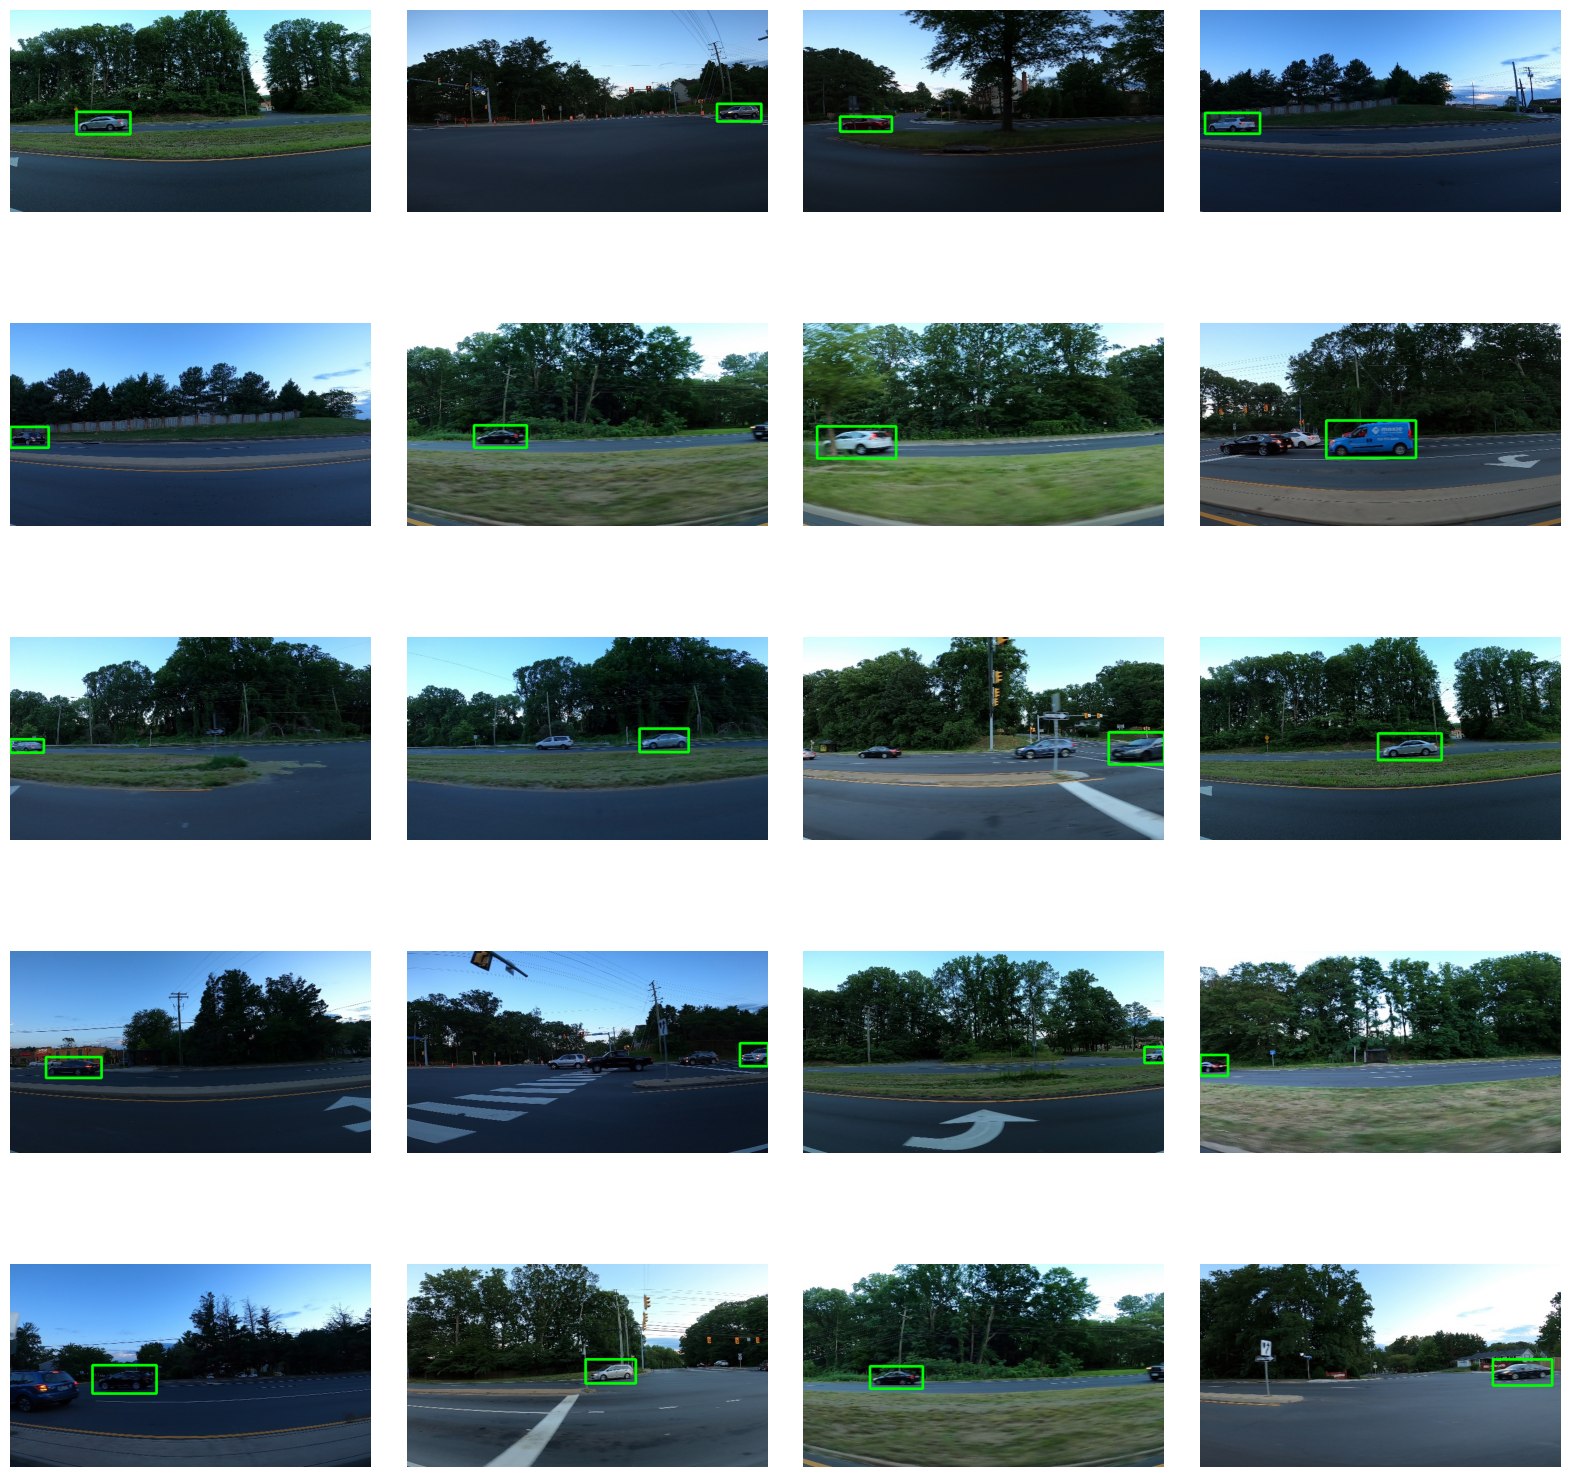

In [9]:
# Посмотрим на полученные размеченные фотографии.
classes = ['car']

images_files = sorted([images_path + '/' + x for x in os.listdir(images_path)])
labels_files = sorted([labels_path + '/' + x for x in os.listdir(labels_path)])

# Пример-список из 20 случайных пар (img.jpg, label.jpg).
indices = [randint(1, len(images_files))-1 for _ in range(20)]
samples = [(images_files[i], labels_files[i]) for i in indices]

# Вывод на экран.
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i, files in enumerate(samples):
  # Чтение.
  image = cv2.cvtColor(cv2.imread(files[0]), cv2.COLOR_BGR2RGB)
  with open(files[1], 'r') as f:
    labels = f.read().strip().split('\n')
    labels = [list(map(float, x.split())) for x in labels if len(x) >= 3]

  # Разметка.
  for label in labels:
    class_id, x_cen, y_cen, w, h = label
    x_min = int((x_cen - w / 2) * image.shape[1])
    y_min = int((y_cen - h / 2) * image.shape[0])
    x_max = int((x_cen + w / 2) * image.shape[1])
    y_max = int((y_cen + h / 2) * image.shape[0])

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

  # Картинка.
  axs[i].imshow(image)
  axs[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# YOLO.

In [10]:
# Конфигурационный файл.
yaml_dataset_path = BASE_PATH + '/dataset.yaml'
with open(yaml_dataset_path, 'w+') as f:
  data = (
      f'path: {BASE_PATH}\n'
      'train: images\n'
      'val: images\n'
      'nc: 1\n\n'
      'names: [\'car\']\n'
  )
  f.write(data)

In [50]:
# Настройка модели.
pretrained = 'yolov8n.pt'
epochs = 25
batch = 16
img_size = 640
model = YOLO(pretrained)

In [19]:
# Обучение.
model.train(
    data=yaml_dataset_path,
    epochs=epochs,
    batch=batch,
    imgsz=img_size,
    verbose=False
)

Ultralytics 8.3.68  Python-3.11.5 torch-2.5.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\Development\university\course03\llm\practice02/content/car-object-detection/data/dataset.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

train: Scanning D:\Development\university\course03\llm\practice02\content\car-object-detection\data\labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
val: Scanning D:\Development\university\course03\llm\practice02\content\car-object-detection\data\labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]

Plotting labels to runs\detect\train3\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.395      2.707      1.092          6        640: 100%|██████████| 23/23 [01:05<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]

                   all        355        355    0.00333          1      0.491      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.283       1.82      1.083          8        640: 100%|██████████| 23/23 [01:00<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


                   all        355        355    0.00331      0.994      0.327      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G       1.33      1.808      1.108          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


                   all        355        355      0.857      0.337       0.79      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.303      1.663       1.11          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

                   all        355        355      0.766      0.701      0.786      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.285      1.505      1.097          3        640: 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

                   all        355        355      0.592      0.732       0.57      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.247      1.294      1.095          6        640: 100%|██████████| 23/23 [00:59<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        355        355      0.773      0.854       0.85      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      1.244      1.229      1.095          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]

                   all        355        355      0.738      0.831      0.825      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.235      1.171      1.067          6        640: 100%|██████████| 23/23 [00:59<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

                   all        355        355      0.759      0.865      0.837      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.176      1.092       1.06          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

                   all        355        355      0.721      0.825      0.823       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.181      1.074      1.052          8        640: 100%|██████████| 23/23 [00:59<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        355        355      0.761      0.863      0.829       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.196      1.026      1.056          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        355        355      0.726      0.944      0.859      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.152     0.9933      1.043          4        640: 100%|██████████| 23/23 [00:59<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        355        355      0.805      0.873       0.87      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.133     0.9372      1.032          7        640: 100%|██████████| 23/23 [00:58<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        355        355      0.763      0.924      0.841      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.151     0.9276      1.037          5        640: 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        355        355      0.778      0.965      0.921      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.137     0.9274      1.042          7        640: 100%|██████████| 23/23 [00:59<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        355        355      0.839      0.898      0.919      0.641


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      1.162      1.013      1.049          2        640: 100%|██████████| 23/23 [00:58<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]

                   all        355        355      0.793      0.936        0.9      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.098     0.9373      1.032          3        640: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        355        355      0.831      0.915      0.908      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.118     0.9085       1.04          3        640: 100%|██████████| 23/23 [00:57<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]

                   all        355        355      0.804      0.924      0.883      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.065      0.862      1.011          2        640: 100%|██████████| 23/23 [00:57<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        355        355      0.846      0.913      0.948      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.053     0.8257      1.021          3        640: 100%|██████████| 23/23 [00:58<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]

                   all        355        355      0.808      0.899      0.905      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.102     0.8072      1.027          3        640: 100%|██████████| 23/23 [00:57<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]

                   all        355        355      0.803      0.965      0.941      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.052     0.7909      1.005          2        640: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

                   all        355        355      0.847      0.932      0.953      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G       1.03     0.7733      1.011          3        640: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

                   all        355        355      0.928      0.915      0.971      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G     0.9992      0.713     0.9928          3        640: 100%|██████████| 23/23 [00:58<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        355        355      0.894      0.953      0.969      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.058     0.7388       1.03          2        640: 100%|██████████| 23/23 [00:57<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

                   all        355        355      0.896       0.95       0.97      0.709



25 epochs completed in 0.499 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.68  Python-3.11.5 torch-2.5.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


                   all        355        355      0.923      0.915      0.971      0.713
Speed: 0.4ms preprocess, 26.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002498ECA0710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

# Результаты.

In [43]:
from glob import glob
from IPython.display import Image, display

In [25]:
# Валидация.
metrics = model.val(split='val')

Ultralytics 8.3.68  Python-3.11.5 torch-2.5.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning D:\Development\university\course03\llm\practice02\content\car-object-detection\data\labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


                   all        355        355      0.923      0.915      0.971      0.713
Speed: 0.4ms preprocess, 28.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train35


In [37]:
print(
    f'Mean avg precision @.5:.95 : {metrics.box.map}\n'
    f'Mean avg precision @ .50   : {metrics.box.map50}\n'
    f'Mean avg precision @ .70   : {metrics.box.map75}\n'
    f'recall:'
    f'\n\tr={metrics.box.r[0]}'
    f'\n\tf1={metrics.box.f1[0]}'
    f'\n\tmaps={metrics.box.maps[0]}'
)

Mean avg precision @.5:.95 : 0.7125709274582774
Mean avg precision @ .50   : 0.9706999143555398
Mean avg precision @ .70   : 0.9082376677388737
recall:
	r=0.9154929577464789
	f1=0.919138978929973
	maps=0.7125709274582774


In [48]:
MODEL_PATH = ('' if 'google.colab' in sys.modules else CWD) + '/runs/detect/'
TRAIN3_PATH = MODEL_PATH + 'train3/'

def draw_plot(pictures, size):
    count = 1
    plt.figure(figsize=(15,10))
    for picture in pictures:
        plt.subplot(size[0], size[1], count)
        picture = plt.imread(TRAIN3_PATH + picture)
        plt.imshow(picture)
        count += 1
    plt.show()

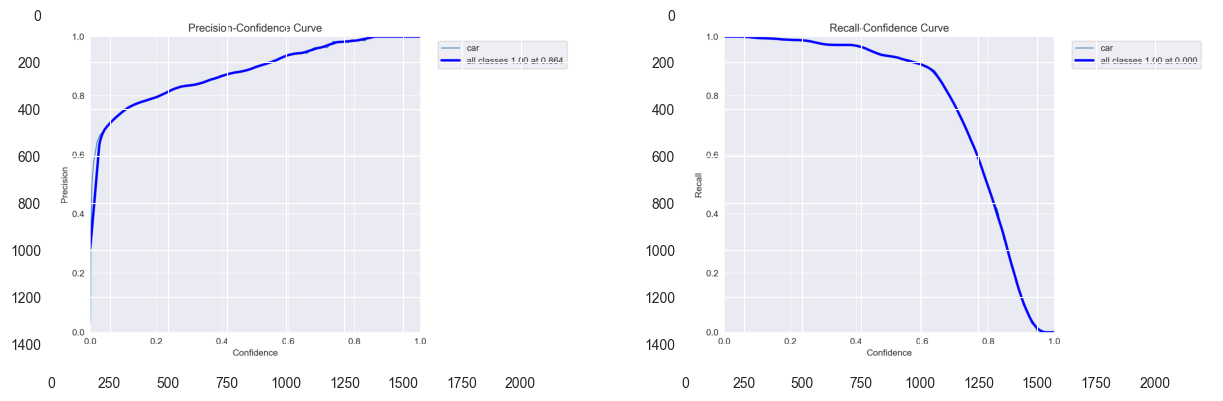

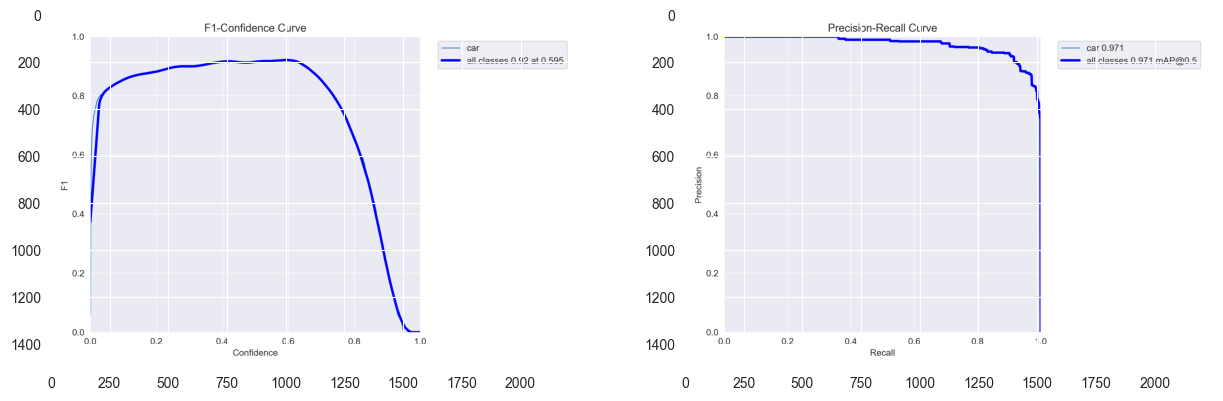

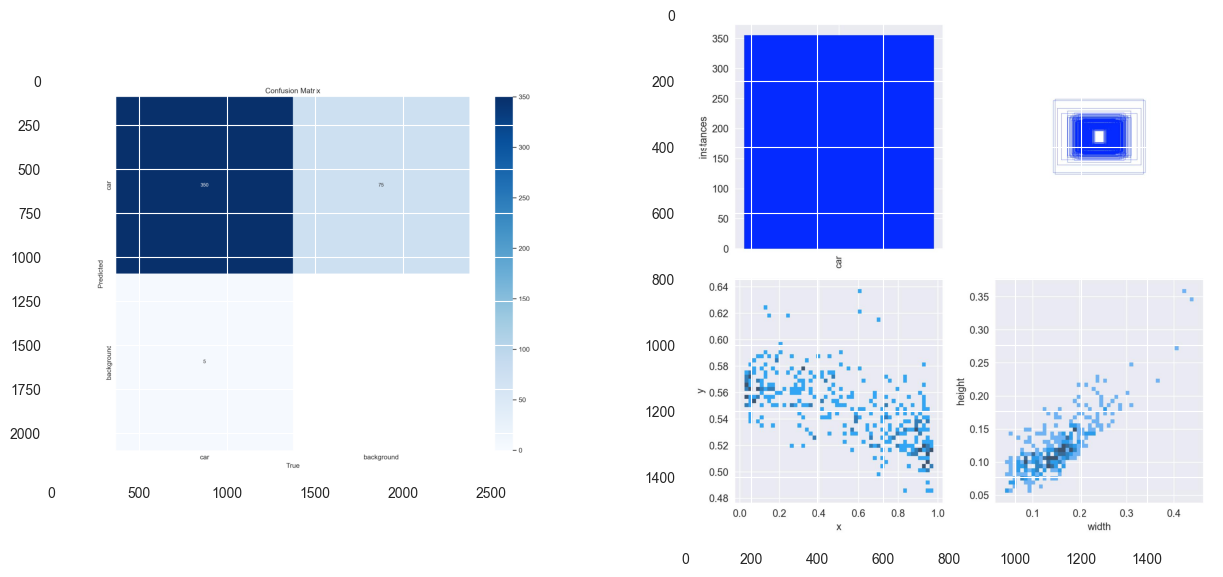

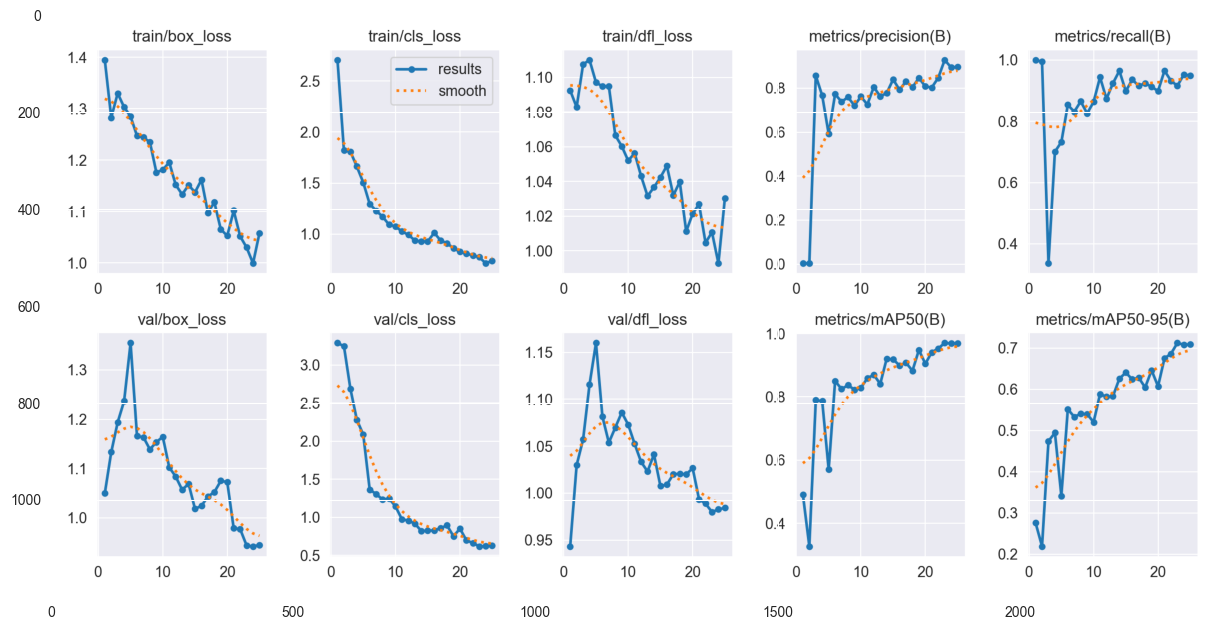

In [42]:
draw_plot(['P_curve.png','R_curve.png'], (1,2))
draw_plot(['F1_curve.png','PR_curve.png'], (1,2))
draw_plot(['confusion_matrix.png','labels.jpg'], (1,2))
draw_plot(['results.png'],(1,1))

In [46]:
results = model.predict(DATA_TEST_PATH, save=True)

Results saved to runs\detect\train37


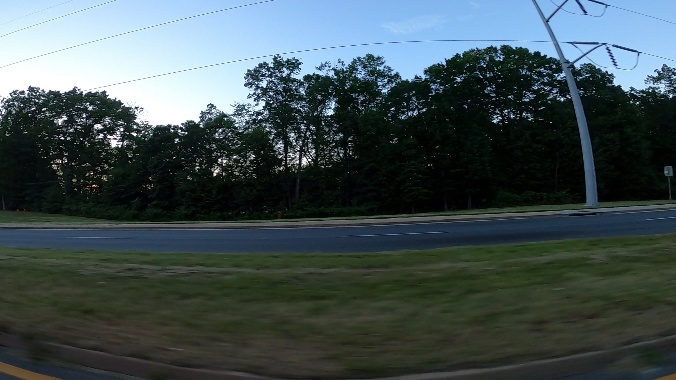

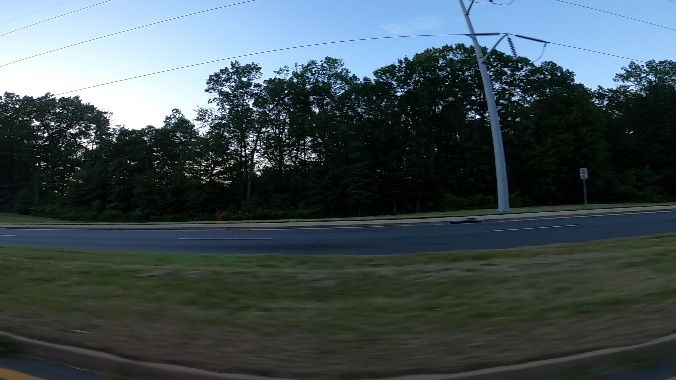

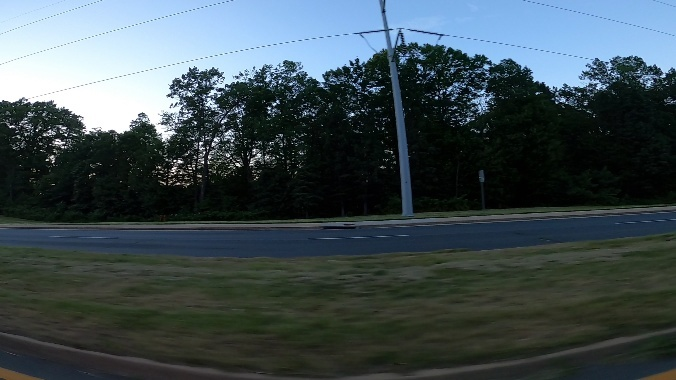

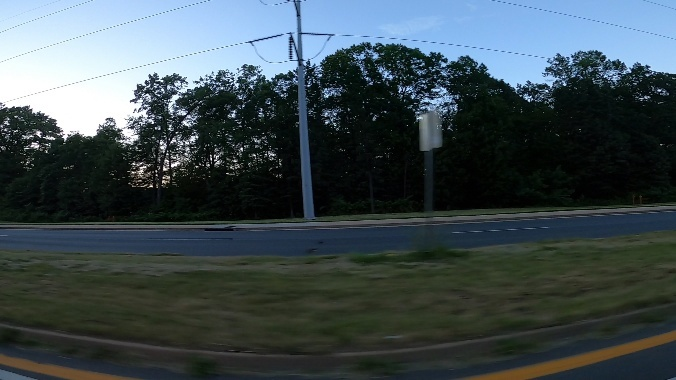

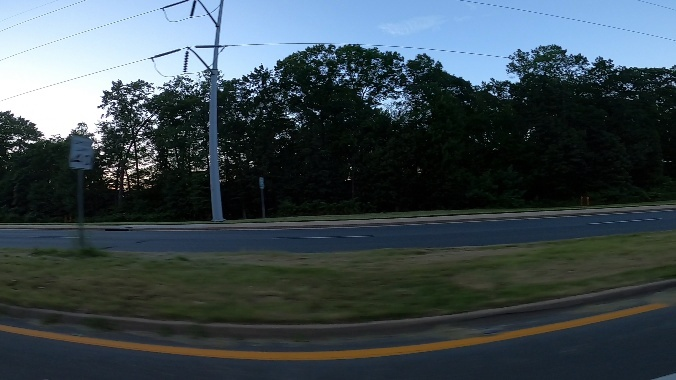

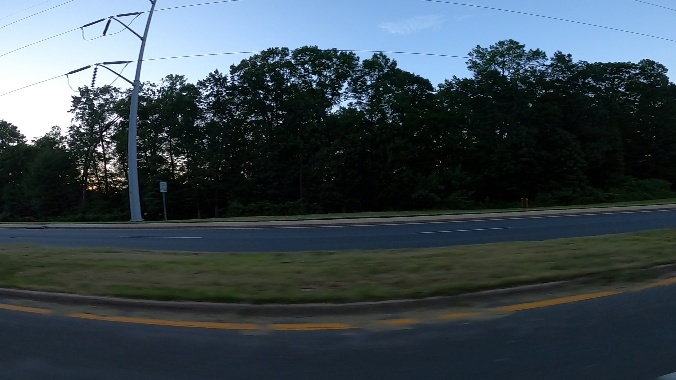

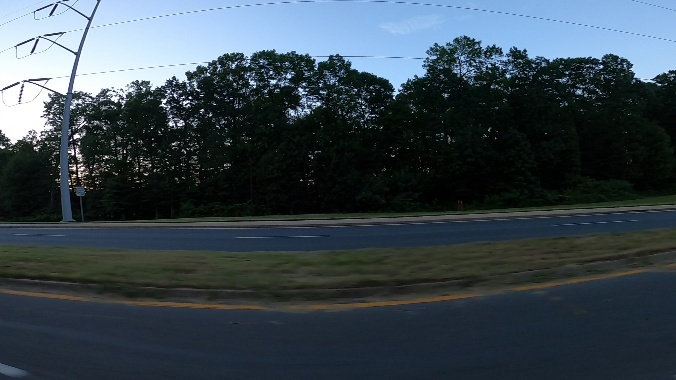

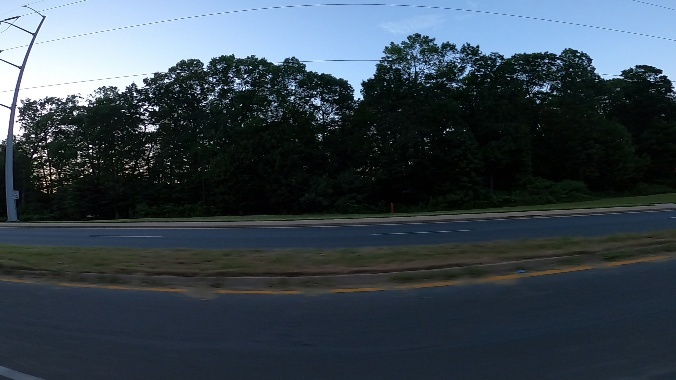

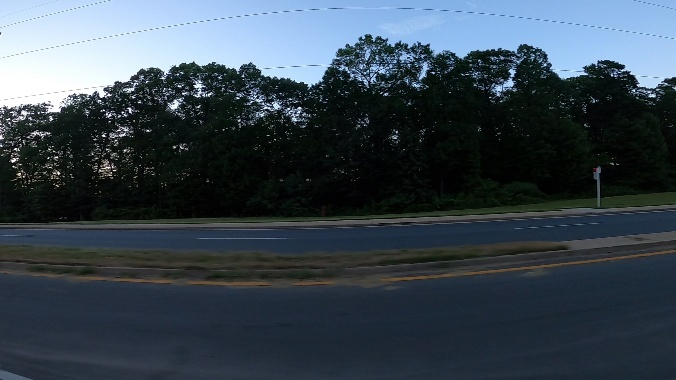

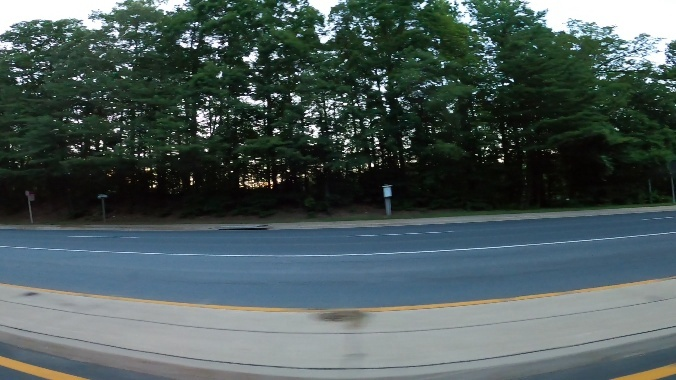

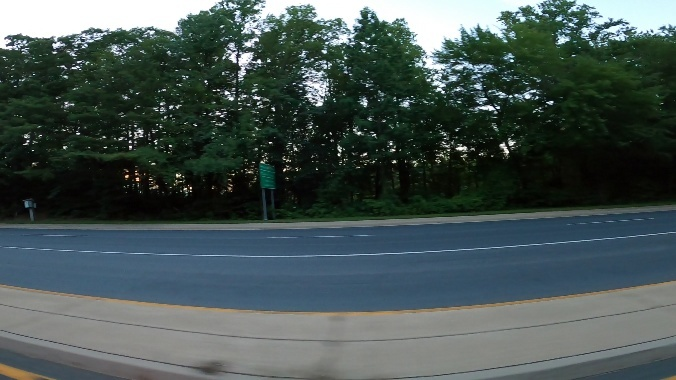

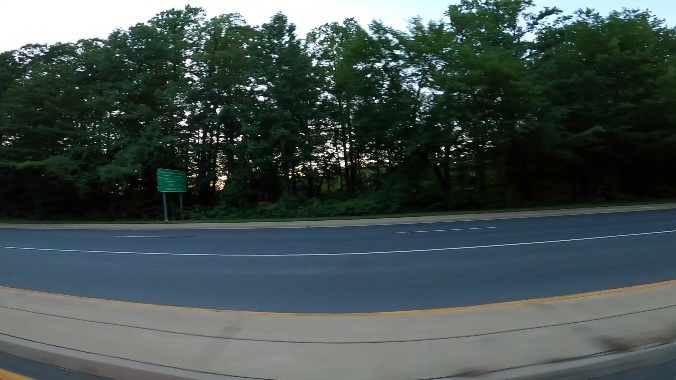

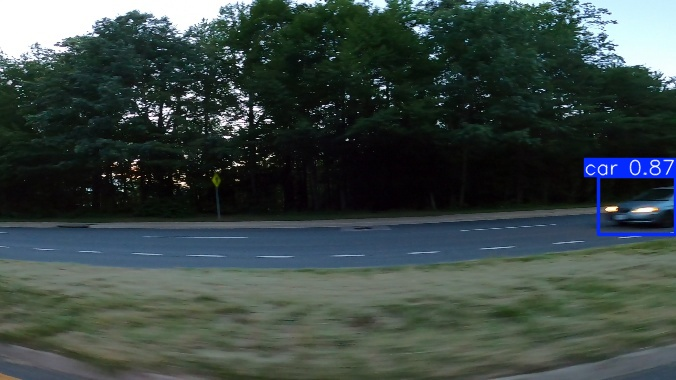

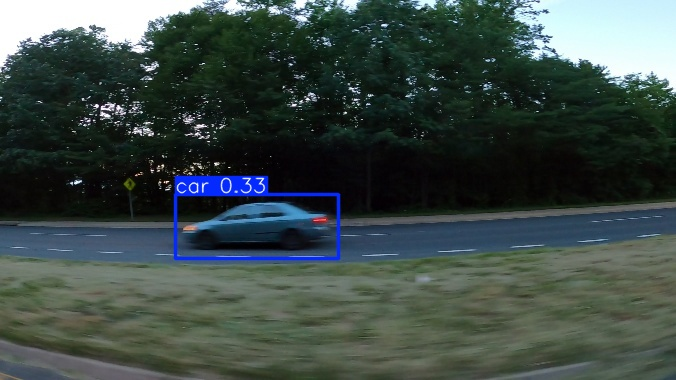

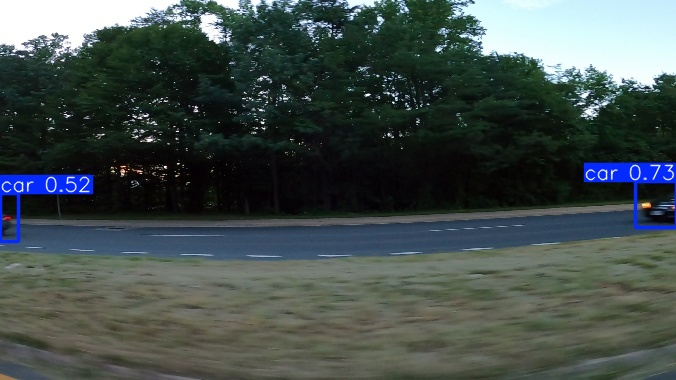

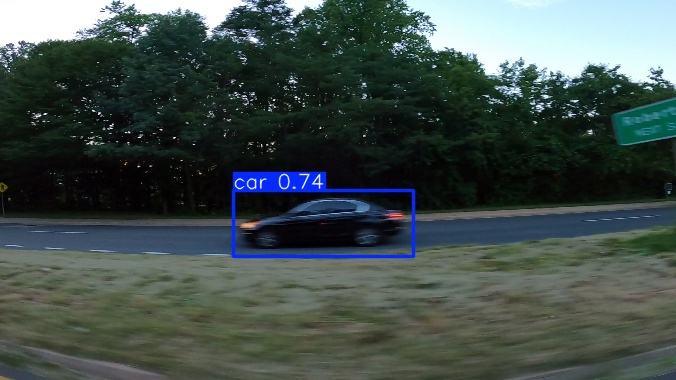

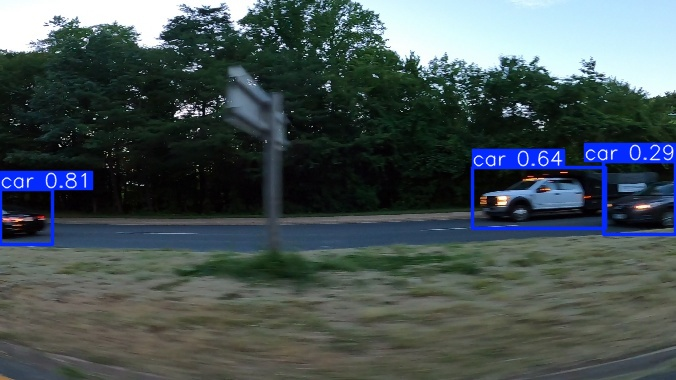

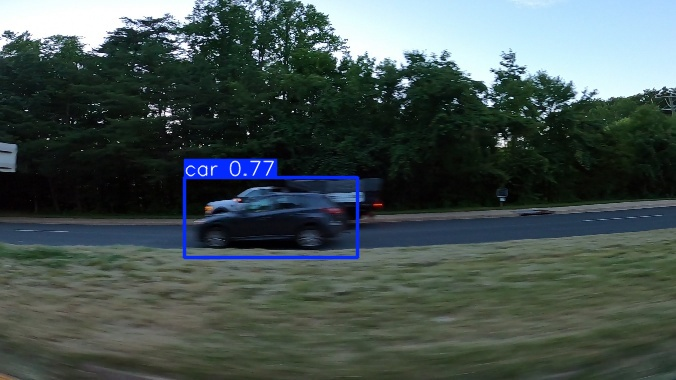

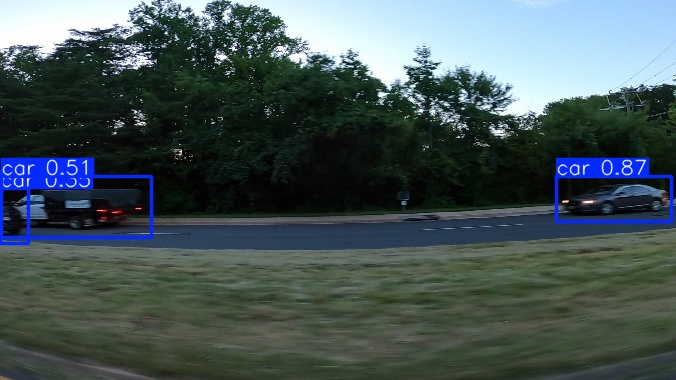

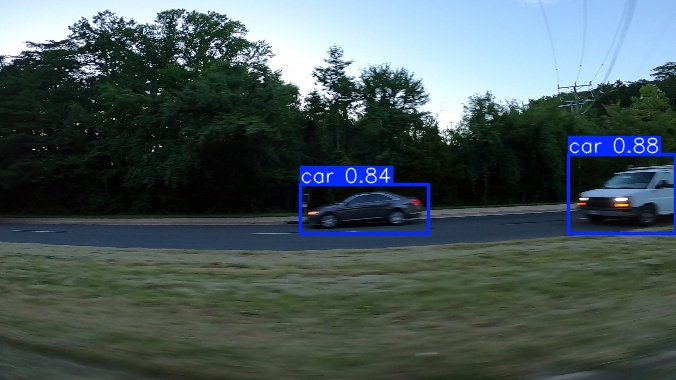

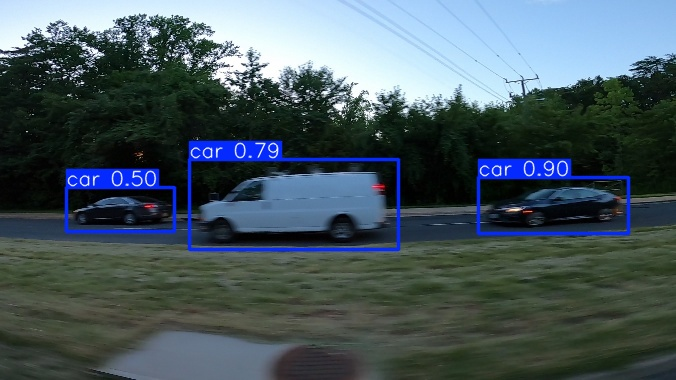

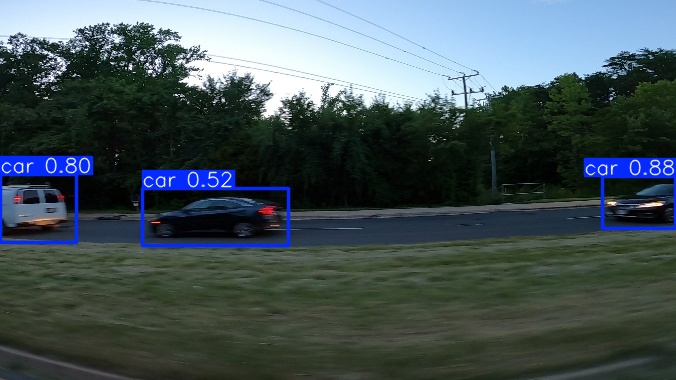

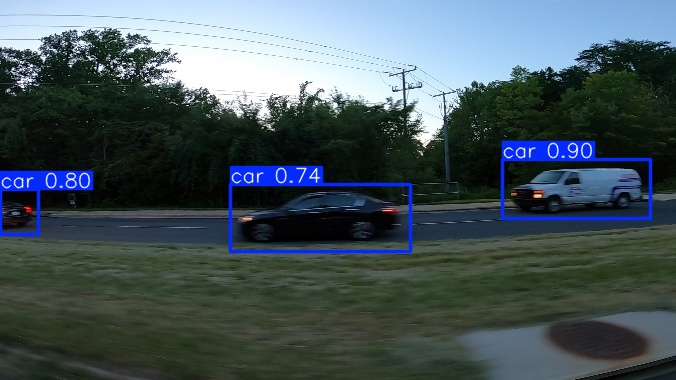

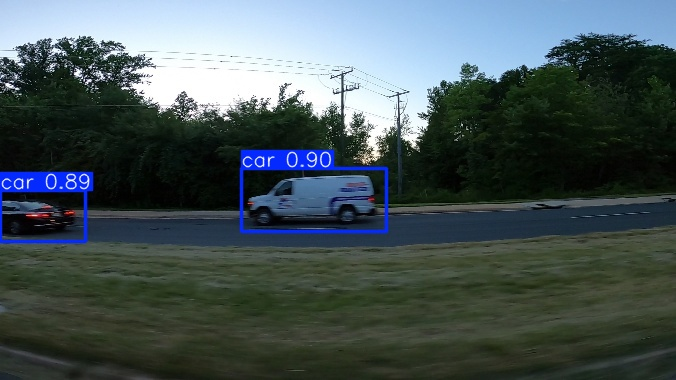

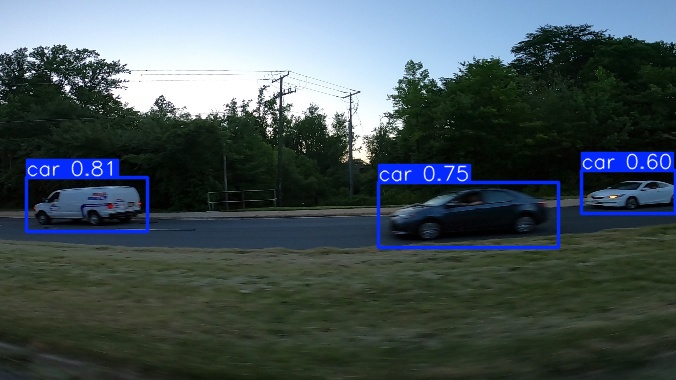

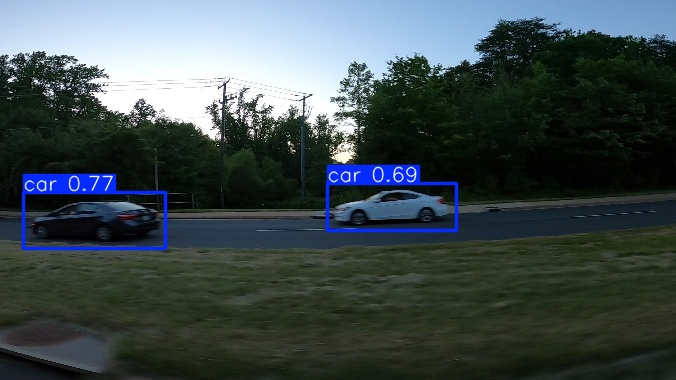

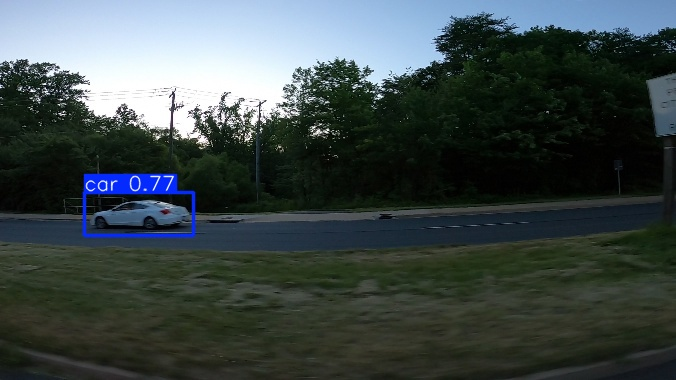

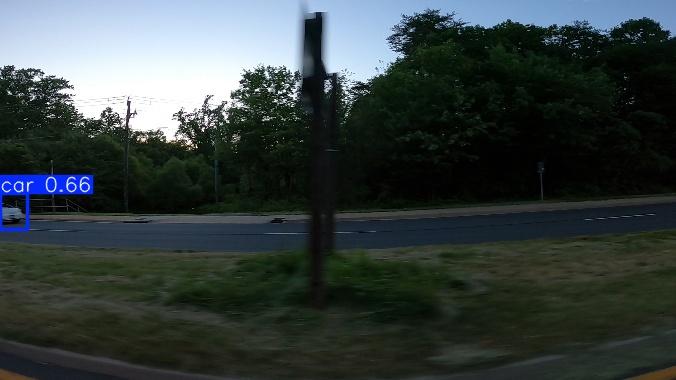

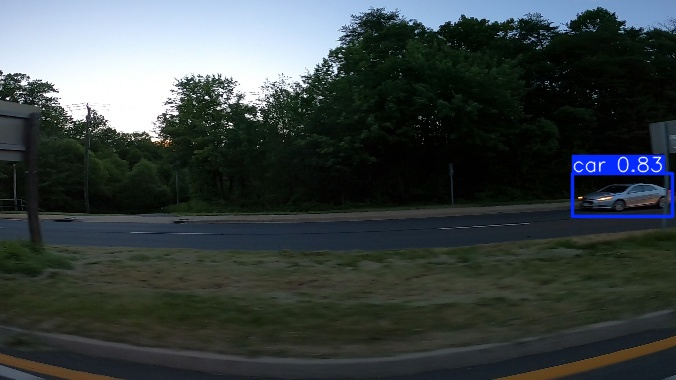

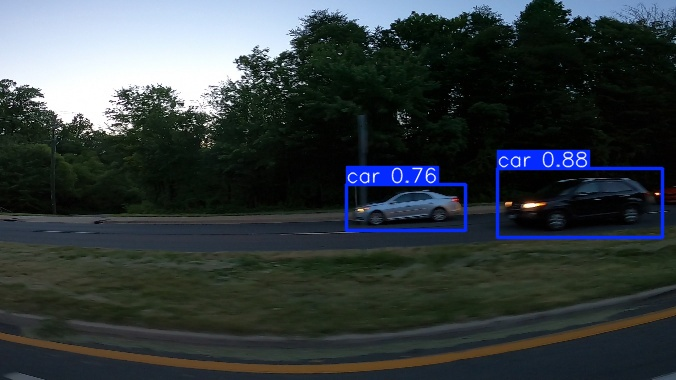

In [49]:
TRAIN37_PATH = MODEL_PATH + 'train37/'
for file_name in glob(TRAIN37_PATH + '*.jpg')[:30]:
    display(Image(filename=file_name, width=600))
    print('\n')